<a href="https://colab.research.google.com/github/StephMcCallum/MSE563-SM/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Metropolis MC Sampling Algorithm for Lennard-Jonesium

In [26]:
import numpy
import random
k_B = 1.0
directions = [numpy.array((1,0,0)),numpy.array((0,-1,0)),numpy.array((-1,0,0)),numpy.array((0,1,0)),numpy.array((0,0,1)),numpy.array((0,0,-1))]
def pbc(site,L): #The convention here is to have positive lattice indices
  for i,s in enumerate(site):
    if s >= L:
      site[i] = s - L
    elif s < 0:
      site[i] = s + L
  return site

class box():
  def __init__(self,N=5,L=4,T=1.0,ideal=False):
    self.L = L
    self.N = N
    self.epsilon = -1
    self.kT = T
    self.ideal = ideal
    self.particles = []
    for i in range(self.N):
      self.particles.append(particle())
      while True:
        rands = self.random_site()
        if not self.occupied(rands):
          self.particles[-1].location = rands
          break
    self.E,self.virial = self.energy()
    self.P = self.pressure()

  def occupied(self,site):
    for p in self.particles:
      if numpy.array_equal(p.location,site):
        return True
    return False

  def random_site(self):
    return numpy.array((random.uniform(0,self.L),random.uniform(0,self.L),random.uniform(0,self.L)))

  def distance(self,site1,site2,epsilon=1.0,sigma=1.0):
    delta = site1 - site2
    r = numpy.linalg.norm(delta)
    if r > (self.L/2):
      delta -= numpy.round(delta/self.L) * self.L #considering PBC
      r = numpy.linalg.norm(delta)
    f_magnitude = 24 * epsilon * (2 * (sigma / r)**12 - (sigma / r)**6) / r
    force = f_magnitude*delta/r #force vector
    return r,force,delta

  def lennard_jones_potential(self,r, epsilon=1.0, sigma=1.0,r_cut=2.5):
    if r == 0:
      return numpy.inf
    if r > r_cut:
      return 0
    potential = 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)
    return potential

  def energy(self):
    energy = 0
    virial_sum = 0
    if self.ideal == True:
      return energy
    for p in self.particles:
      for n in self.particles:
        if self.occupied(n.location) and not numpy.array_equal(n.location,p.location):
          r,force,delta = self.distance(p.location,n.location)
          energy += self.lennard_jones_potential(r)
          virial_sum += numpy.dot(force, delta)
    return energy/2, virial_sum

  def pressure(self):
    density = self.N/(self.L**3)
    P_ideal = (density*k_B*self.kT)/(self.L**3)
    pressure = P_ideal + (self.virial/(3*(self.L**3)))
    return pressure


  def __repr__(self):
    m = numpy.zeros((self.L,self.L,self.L))
    for p in self.particles:
      m[tuple(p.location)] = 1
    return str(m)

class particle():
  def __init__(self):
    self.location = numpy.array((-1.0,-1.0,-1.0))

class simulation():
  def __init__(self,N,L,T,steps,ideal_gas=False,seed=2):
    numpy.random.seed(seed)
    self.box = box(N,L,T)
    self.accepted = 0
    self.rejected = 0
    self.T = T
    self.energies = numpy.zeros(steps)
    for i in range(steps):
      self.trial_move()
      self.energies[i] = self.box.E/N
    self.C_v = self.heat_capacity()
    self.plot = self.plot(self.box.particles,self.box.L)


  def heat_capacity(self):
    mean_energy = numpy.mean(self.energies)
    mean_energy_squared = numpy.mean(numpy.array(self.energies)**2)
    k_B = 1.0
    return (mean_energy_squared - mean_energy**2) / (self.T**2 * k_B)

  def trial_move(self):
    p = numpy.random.choice(self.box.particles)
    old = p.location
    oldE = self.box.E
    trial = self.box.random_site()
    if not self.box.occupied(trial):
      p.location = trial
      E = self.box.energy()[0]
      dE = E - oldE
      if numpy.random.rand() < numpy.exp(-dE/self.box.kT):
        self.box.E = E
        self.accepted += 1
        return
    p.location = old #need to reject moves that are overlaps
    self.box.E = oldE
    self.rejected += 1

  def plot(self, particles, L, title = "Current configuration"):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    for p in particles:
      ax.scatter(p.location[0], p.location[1], p.location[2], c='blue', marker='o')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_zlim(0, L)
    plt.title(title)
    plt.show()



In [34]:
k_B = 1.0
ideal_gas_C_v = 3/2*k_B

# Characterize performance
## Extremes of state

<ipython-input-26-99a736efe7b5>:118: RuntimeWarning: overflow encountered in exp
  if numpy.random.rand() < numpy.exp(-dE/self.box.kT):


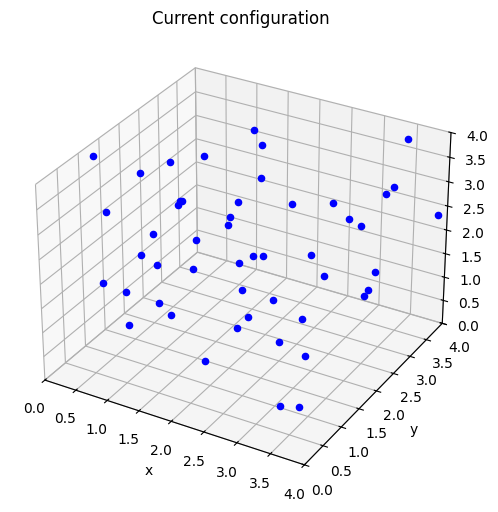

Acceptance rate: 0.104


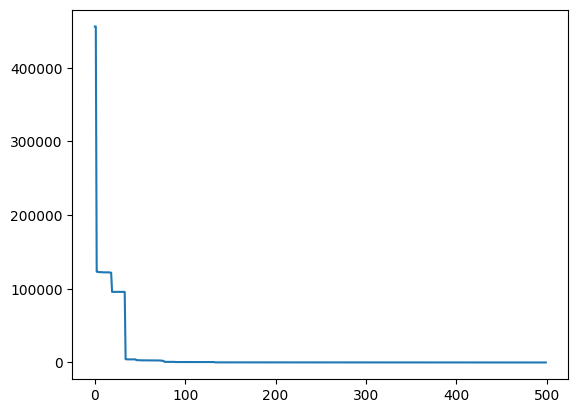

In [37]:
#Extreme: high density, low temperature
import matplotlib.pyplot as plt
s = simulation(N=50,L=4,T=0.001,steps=500,seed = 2) #density of 0.8
plt.plot(s.energies)
print("Acceptance rate:", s.accepted/500)

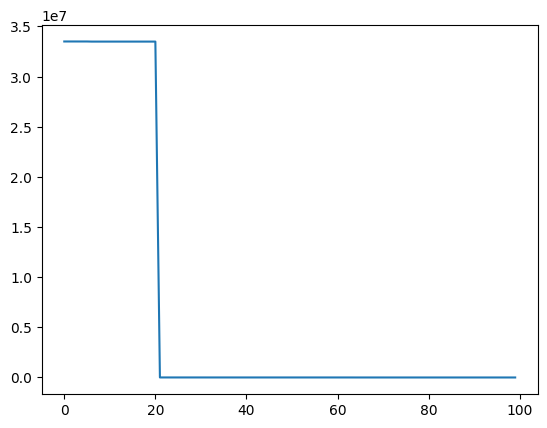

In [33]:
plt.plot(s.energies[:100])

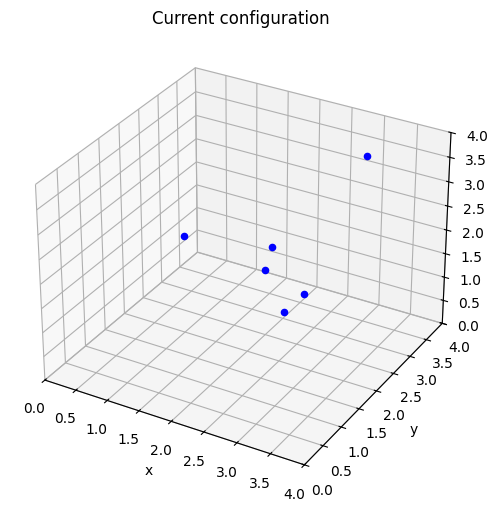

66.1164878008569 38.722232722308824 0.269


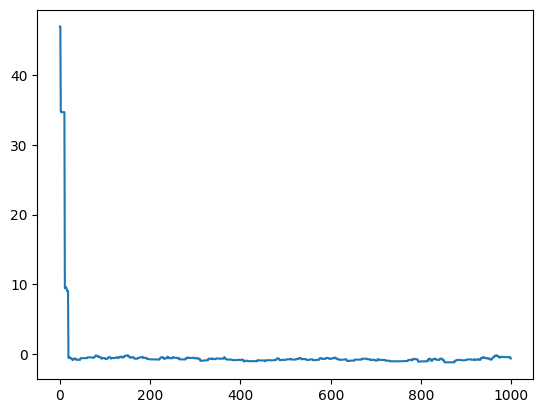

In [36]:
import matplotlib.pyplot as plt
s = simulation(N=6,L=4,T=0.5,steps=1000, seed = 2)
plt.plot(s.energies)
print(s.C_v,s.box.P,s.accepted/1000)

## Too small, too big

In [13]:
import time
for N in [5,10,50,100,200,500]:
  t1 = time.perf_counter()
  s = simulation(N=N,L=100,T=0.5,steps=100, seed = 2)
  t2 = time.perf_counter()
  print("\nN=",N,"seconds/100steps =", t2-t1)
  if t2-t1 > 30:
    print("Taking a minute for 200 steps. TOO SLOW")
    break



N= 5 seconds/100steps = 0.11470363499995528

N= 10 seconds/100steps = 0.5911562629999025

N= 50 seconds/100steps = 32.91948636900008
Taking a minute for 200 steps. TOO SLOW


In [21]:
print(s.heat_capacity())

AttributeError: 'simulation' object has no attribute 'heat_capacity'

In [ ]:
import matplotlib.pyplot as plt
energies = []
Ts =  [4,2,1,0.9,0.7, 0.5, 0.2]
for T in Ts:
  print("T=",T)
  s = simulation(N=20,L=7,T=T,steps=10000, seed = numpy.random.randint(100000))
  energies.append(s.energies)

T= 4
T= 2
T= 1
T= 0.9
T= 0.7
T= 0.5
T= 0.2


In [ ]:
for T,e in zip(Ts,energies):
  print("T=",T, ", <E>=", numpy.array(e).mean())
#hard to say from the energy averages when N<10, but looking at the configurations
#maybe clustering starts to happen more around 0.7
#though the plots look qualitatively different at 0.5.

#rerunning with N=20, L=7, maxT=10000, looks like it'll take about 3 min.

T= 4 , <E>= -0.8635200000000001
T= 2 , <E>= -0.9285399999999999
T= 1 , <E>= -1.0862749999999999
T= 0.9 , <E>= -1.10584
T= 0.7 , <E>= -1.1992800000000001
T= 0.5 , <E>= -1.3737799999999998
T= 0.2 , <E>= -1.5804500000000004


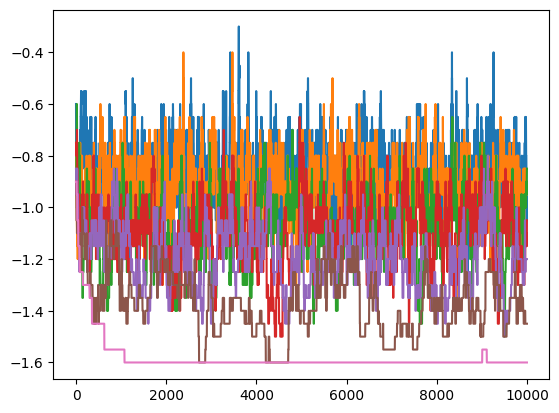

In [ ]:
for e in energies:
  plt.plot(e)
# Yeah, 0.2 clusters up at the energy minimum, 0.5 touches it, and 0.7 starts clumping.